## ResNet in PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.transforms as T
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

import os
import pathlib
import zipfile
import shutil

### Data Preparation

We once again download and preprocess the cats vs dogs dataset from Kaggle.

In [2]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -p /content/datasets  -c dogs-vs-cats

 98% 797M/812M [00:16<00:00, 34.3MB/s]
100% 812M/812M [00:16<00:00, 52.1MB/s]


In [6]:
root = pathlib.Path('/content/datasets')

In [7]:
if not os.path.exists(root / 'dogs-vs-cats'):
  with zipfile.ZipFile(root / 'dogs-vs-cats.zip', 'r') as zip_ref:
      zip_ref.extractall(root / 'dogs-vs-cats')
      
  with zipfile.ZipFile(root / 'dogs-vs-cats/train.zip', 'r') as zip_ref:
      zip_ref.extractall(root / 'dogs-vs-cats')


In [8]:
original_path = root / 'dogs-vs-cats'
new_path = root / 'dogs_vs_cats_prepared'

In [9]:
# prepare list of files
file_names = os.listdir(original_path / 'train')
test_file_names = file_names[0:5000]
val_file_names = file_names[5000:10000]
train_file_names = file_names[10000:]

In [10]:
# prepare dirs
for directory in ["train", "test", "val"]:
    for category in ["cat", "dog"]:
        new_dir = new_path / directory / category
        if os.path.exists(new_dir):
            shutil.rmtree(new_dir)
        os.makedirs(new_dir)

In [11]:
def copy_files(old_dir, new_dir, files_list):
    for idx, filename in enumerate(files_list):
        src = old_dir / filename
        if filename.startswith('cat'):
            dst = new_dir / 'cat' / filename
        elif filename.startswith('dog'):
            dst = new_dir / 'dog' / filename
        else:
            continue
            
        shutil.copyfile(src=src, dst=dst)

In [12]:
copy_files(old_dir=original_path / "train", new_dir=new_path / 'train', files_list=train_file_names)
copy_files(old_dir=original_path / "train", new_dir=new_path / 'val', files_list=val_file_names)
copy_files(old_dir=original_path / "train", new_dir=new_path / 'test', files_list=test_file_names)

In [13]:
root = new_path

In [14]:
train_transform = T.Compose([T.Resize((256, 256)), 
                             T.RandomCrop(size=(224, 224)),
                             T.ToTensor()])

test_transform = T.Compose([T.Resize((224, 224)), 
                                T.ToTensor()])

In [15]:
train_dataset = ImageFolder(root=root / 'train', transform=train_transform)
val_dataset = ImageFolder(root=root / 'val', transform=test_transform)
test_dataset = ImageFolder(root=root / 'test', transform=test_transform)

We can keep the batch size of 256, as in the original paper. While we have a lot of layers, this architecture is relatively lightweght.

In [16]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE=256

In [17]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=False)

### Model Creation and Training

This basic block corresponds to the one described above. We check if the number of channel changes. If it does we half the image resolution.

In [18]:
class BasicBlock(nn.Module):
  def __init__(self,
               in_channels,
               out_channels):
    super().__init__()
    
    first_stride=1
    if out_channels != in_channels:
      first_stride=2

    self.residual = nn.Sequential(
        nn.Conv2d(in_channels, 
                  out_channels, 
                  kernel_size=3, 
                  stride=first_stride, 
                  padding=1, 
                  bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, 
                  out_channels, 
                  kernel_size=3, 
                  stride=1, 
                  padding=1, 
                  bias=False),
        nn.BatchNorm2d(out_channels))

    self.downsampling = None
    if out_channels != in_channels:
      self.downsampling = nn.Sequential(
          nn.Conv2d(in_channels, 
                    out_channels,
                    kernel_size=1,
                    stride=2,
                    bias=False),
          nn.BatchNorm2d(out_channels))
  
  def forward(self, x):
    identity = x
    if self.downsampling:
      identity = self.downsampling(identity)
    
    x = self.residual(x)
    return torch.relu(x + identity)

We save the number of output channels of the basic block in a config file. This configuration can be used to create the whole network.

In [19]:
cfg = [64, 64, 64,
       128, 128, 128, 128,
       256, 256, 256, 256, 256, 256, 
       512, 512, 512]

We do not introduce any new components. We just utilize the configuration and stack layer after layer. 

In [20]:
class Model(nn.Module):
  
  def __init__(self, cfg):
    super().__init__()
    self.cfg = cfg
    self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu1 = nn.ReLU(inplace=True)
    self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
    self.blocks = self._create_network()
    self.classifier = nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(cfg[-1], 1))

  def _create_network(self):
    blocks = []
    prev_channels = 64
    for channels in self.cfg:
      blocks += [BasicBlock(prev_channels, channels)]
      prev_channels = channels
    return nn.Sequential(*blocks)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu1(x)
    x = self.maxpool1(x)
    x = self.blocks(x)
    x = self.classifier(x)
    return x

In [21]:
def track_performance(dataloader, model, criterion):
    # switch to evaluation mode
    model.eval()
    num_samples = 0
    num_correct = 0
    loss_sum = 0
    
    # no need to calculate gradients
    with torch.inference_mode():
        for batch_idx, (features, labels) in enumerate(dataloader):
            features = features.to(DEVICE)
            labels = labels.to(DEVICE).view(-1, 1).float()
            logits = model(features)
            probs = torch.sigmoid(logits)
                        
            predictions = (probs > 0.5).float()
            num_correct += (predictions == labels).sum().item()
            
            loss = criterion(logits, labels)
            loss_sum += loss.cpu().item()
            num_samples += len(features)
    
    # we return the average loss and the accuracy
    return loss_sum/num_samples, num_correct/num_samples

In [22]:
def plot_history(history):
    fig = plt.figure(figsize=(12, 5))

    fig.add_subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Training Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Cross-Entropy")
    plt.legend()
    
    fig.add_subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Training Accuracy")
    plt.plot(history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.show()

In [23]:
def train(num_epochs, train_dataloader, val_dataloader, model, criterion, optimizer, scheduler=None):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    
    model.to(DEVICE)
    
    for epoch in range(num_epochs):
        for batch_idx, (features, labels) in enumerate(train_dataloader):
            model.train()
            features = features.to(DEVICE)
            labels = labels.to(DEVICE).view(-1, 1).float()
            
            # Empty the gradients
            optimizer.zero_grad()
            
            # Forward Pass
            logits = model(features)
            
            # Calculate Loss
            loss = criterion(logits, labels)
            
            # Backward Pass
            loss.backward()
            
            # Gradient Descent
            optimizer.step()
            
        train_loss, train_acc = track_performance(train_dataloader, model, criterion)
        val_loss, val_acc = track_performance(val_dataloader, model, criterion)

        if scheduler:
          scheduler.step(val_loss)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f'Epoch: {epoch+1:>2}/{num_epochs} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}')
    return history            
            

In [25]:
model = Model(cfg)
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       patience=2,
                                                       verbose=True)

criterion = nn.BCEWithLogitsLoss()

The validation accuracy after 10 episodes is slightly worse, than the one we observed with VGG or GoogLeNet. 

In [26]:
history = train(10, train_dataloader, val_dataloader, model, criterion, optimizer, scheduler)

Epoch:  1/10 | Train Loss: 0.00514 | Val Loss: 0.00534 | Train Acc: 0.521 | Val Acc: 0.522
Epoch:  2/10 | Train Loss: 0.00313 | Val Loss: 0.00333 | Train Acc: 0.586 | Val Acc: 0.577
Epoch:  3/10 | Train Loss: 0.00204 | Val Loss: 0.00214 | Train Acc: 0.750 | Val Acc: 0.751
Epoch 00004: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  4/10 | Train Loss: 0.00254 | Val Loss: 0.00270 | Train Acc: 0.692 | Val Acc: 0.689
Epoch:  5/10 | Train Loss: 0.00098 | Val Loss: 0.00121 | Train Acc: 0.895 | Val Acc: 0.871
Epoch:  6/10 | Train Loss: 0.00086 | Val Loss: 0.00113 | Train Acc: 0.910 | Val Acc: 0.879
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  7/10 | Train Loss: 0.00083 | Val Loss: 0.00115 | Train Acc: 0.912 | Val Acc: 0.881
Epoch:  8/10 | Train Loss: 0.00071 | Val Loss: 0.00105 | Train Acc: 0.927 | Val Acc: 0.890
Epoch:  9/10 | Train Loss: 0.00070 | Val Loss: 0.00104 | Train Acc: 0.929 | Val Acc: 0.893
Epoch 00010: reducing learning rate of group 0 to 1.0000e

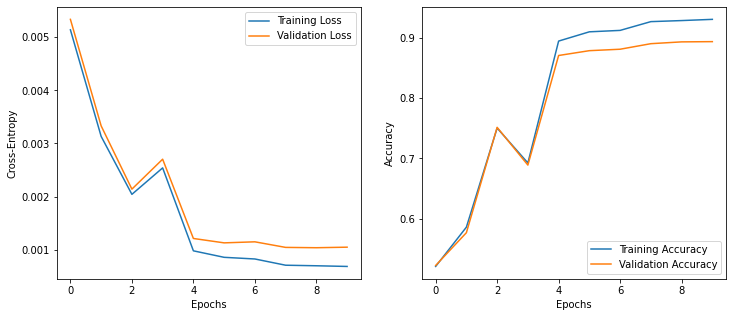

In [27]:
plot_history(history)

### Transfer Learning

In [28]:
from torchvision.models import resnet34

In [29]:
model = resnet34(weights='DEFAULT', progress=False)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


In [30]:
for param in model.parameters():
  param.requires_grad = False

In [31]:
model.fc = nn.Linear(in_features=512, out_features=1)

In [32]:
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       patience=2,
                                                       verbose=True)

criterion = nn.BCEWithLogitsLoss()

In [33]:
history = train(10, train_dataloader, val_dataloader, model, criterion, optimizer, scheduler)

Epoch:  1/10 | Train Loss: 0.00021 | Val Loss: 0.00022 | Train Acc: 0.981 | Val Acc: 0.978
Epoch:  2/10 | Train Loss: 0.00019 | Val Loss: 0.00019 | Train Acc: 0.982 | Val Acc: 0.982
Epoch:  3/10 | Train Loss: 0.00017 | Val Loss: 0.00018 | Train Acc: 0.985 | Val Acc: 0.984
Epoch 00004: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  4/10 | Train Loss: 0.00018 | Val Loss: 0.00018 | Train Acc: 0.983 | Val Acc: 0.984
Epoch:  5/10 | Train Loss: 0.00016 | Val Loss: 0.00017 | Train Acc: 0.986 | Val Acc: 0.984
Epoch:  6/10 | Train Loss: 0.00016 | Val Loss: 0.00017 | Train Acc: 0.986 | Val Acc: 0.984
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  7/10 | Train Loss: 0.00016 | Val Loss: 0.00017 | Train Acc: 0.986 | Val Acc: 0.985
Epoch:  8/10 | Train Loss: 0.00016 | Val Loss: 0.00017 | Train Acc: 0.985 | Val Acc: 0.985
Epoch:  9/10 | Train Loss: 0.00016 | Val Loss: 0.00017 | Train Acc: 0.986 | Val Acc: 0.983
Epoch 00010: reducing learning rate of group 0 to 1.0000e

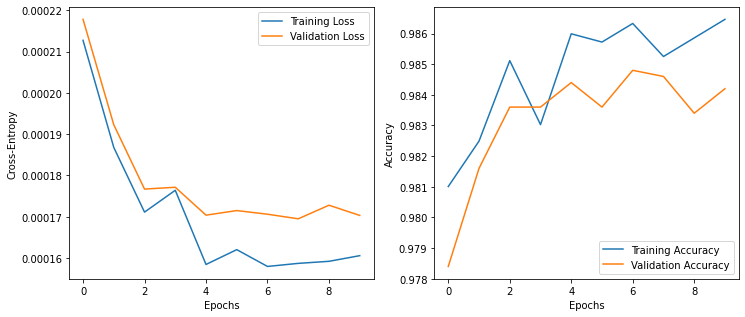

In [34]:
plot_history(history)